# **Laptop Prices Analysis**

### **Objective**

**The objective of this project is to analyze laptop pricing data to understand price distribution, brand-wise trends, and the impact of hardware specifications such as RAM and storage on laptop prices. The analysis aims to extract meaningful insights that can help customers make informed purchasing decisions and help businesses understand market pricing strategies.**

### **Dataset Overview**

**The dataset contains information about various laptops, including brand, price, RAM, storage, and other specifications.
The data was sourced in CSV format and represents real-world laptop listings with different configurations and price ranges.**

**Step 1:Importing Required Libraries**

In [1]:
from __future__ import annotations

import os
import re
import warnings
from dataclasses import dataclass
from typing import Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# In Jupyter, this makes plots display in the output cell
%matplotlib inline

**Step 2: Config + Folders**

In [4]:
@dataclass(frozen=True)
class Config:
    data_path: str = r"C:\Users\Prath\Downloads\laptop_prices.csv"
    out_dir: str = "outputs_laptop_prices"
    tables_dir: str = "tables"
    charts_dir: str = "charts"
    dpi: int = 180

cfg = Config()

TABLES_DIR = os.path.join(cfg.out_dir, cfg.tables_dir)
CHARTS_DIR = os.path.join(cfg.out_dir, cfg.charts_dir)
os.makedirs(TABLES_DIR, exist_ok=True)
os.makedirs(CHARTS_DIR, exist_ok=True)

print("✅ Tables:", os.path.abspath(TABLES_DIR))
print("✅ Charts:", os.path.abspath(CHARTS_DIR))

✅ Tables: C:\Users\Prath\outputs_laptop_prices\tables
✅ Charts: C:\Users\Prath\outputs_laptop_prices\charts


**Step 3: Using Some Helper Functions**

In [5]:
def safe_filename(name: str) -> str:
    name = str(name).strip().lower()
    name = re.sub(r"[^a-z0-9]+", "_", name)
    return name.strip("_") or "file"

def export_csv(df: pd.DataFrame, filename: str) -> str:
    path = os.path.join(TABLES_DIR, f"{safe_filename(filename)}.csv")
    df.to_csv(path, index=False, encoding="utf-8-sig")
    return os.path.abspath(path)

def save_and_show(filename: str, dpi: int = 180) -> str:
    """
    Saves the current matplotlib figure and also displays it in the notebook.
    """
    path = os.path.join(CHARTS_DIR, filename)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()     # ✅ show in notebook
    plt.close()    # ✅ close after showing
    print("✅ Saved chart:", os.path.abspath(path))
    return os.path.abspath(path)

def find_price_col(df: pd.DataFrame) -> Optional[str]:
    candidates = [c for c in df.columns if "price" in c.lower() or "cost" in c.lower()]
    if not candidates:
        return None
    candidates = sorted(candidates, key=lambda x: (x.lower() != "price", len(x)))
    return candidates[0]

def clean_text_col(df: pd.DataFrame, col: str) -> None:
    df[col] = df[col].astype(str).str.strip()
    df.loc[df[col].str.lower().isin(["nan", "none", "null", ""]), col] = np.nan

def to_numeric_series(s: pd.Series) -> pd.Series:
    # Handles ₹, commas, "INR", spaces, and "45k"
    x = s.astype(str).str.replace(",", "", regex=False)
    x = x.str.replace("₹", "", regex=False).str.replace("INR", "", regex=False)
    x = x.str.replace(r"\s+", "", regex=True)

    def parse_val(v: str) -> float:
        vlow = v.lower()
        if vlow in ["nan", "none", "null", ""]:
            return np.nan
        if vlow.endswith("k"):
            try:
                return float(vlow[:-1]) * 1000
            except:
                return np.nan
        vlow = re.sub(r"[^0-9.]+", "", vlow)
        try:
            return float(vlow)
        except:
            return np.nan

    return x.apply(parse_val)

def parse_gb(text: str) -> float:
    if pd.isna(text):
        return np.nan
    t = str(text).lower()
    m_tb = re.search(r"(\d+(\.\d+)?)\s*tb", t)
    if m_tb:
        return float(m_tb.group(1)) * 1024
    m_gb = re.search(r"(\d+(\.\d+)?)\s*gb", t)
    if m_gb:
        return float(m_gb.group(1))
    return np.nan

def group_stats(df: pd.DataFrame, group_col: str, price_col: str) -> pd.DataFrame:
    out = (df.groupby(group_col, dropna=False)[price_col]
           .agg(count="count", avg_price="mean", median_price="median", min_price="min", max_price="max")
           .reset_index())
    out = out.sort_values(["count", "avg_price"], ascending=[False, False])
    return out

**Step 4: Load Data**

In [6]:
df_raw = pd.read_csv(cfg.data_path)
df_raw.columns = [c.strip() for c in df_raw.columns]

print("\n✅ Loaded rows:", len(df_raw))
print("✅ Columns:", df_raw.columns.tolist())

price_col = find_price_col(df_raw)
if price_col is None:
    raise ValueError("❌ Price column not found. Ensure column name includes 'price' or 'cost'.")

print("🎯 Price column:", price_col)



✅ Loaded rows: 1275
✅ Columns: ['Company', 'Product', 'TypeName', 'Inches', 'Ram', 'OS', 'Weight', 'Price_euros', 'Screen', 'ScreenW', 'ScreenH', 'Touchscreen', 'IPSpanel', 'RetinaDisplay', 'CPU_company', 'CPU_freq', 'CPU_model', 'PrimaryStorage', 'SecondaryStorage', 'PrimaryStorageType', 'SecondaryStorageType', 'GPU_company', 'GPU_model']
🎯 Price column: Price_euros


**Step 5:Cleaning + Data Quality**

In [7]:
df = df_raw.copy()

# Clean text columns
for c in df.columns:
    if df[c].dtype == "object":
        clean_text_col(df, c)

# Convert price to numeric
df[price_col] = to_numeric_series(df[price_col])

# Remove duplicates
dup_count = int(df.duplicated().sum())
df = df.drop_duplicates().copy()

# Remove invalid price rows
invalid_price = int(df[price_col].isna().sum() + (df[price_col] <= 0).sum())
df = df[df[price_col].notna() & (df[price_col] > 0)].copy()

In [8]:
# Create derived columns (best effort)
# Brand
brand_candidates = [c for c in df.columns if c.lower() in ["brand", "company", "manufacturer", "oem"]]
if brand_candidates:
    df["Brand"] = df[brand_candidates[0]]
else:
    name_candidates = [c for c in df.columns if any(k in c.lower() for k in ["name", "model", "product", "laptop"])]
    df["Brand"] = df[name_candidates[0]].astype(str).str.split().str[0] if name_candidates else np.nan

# RAM_GB
ram_cols = [c for c in df.columns if "ram" in c.lower()]
df["RAM_GB"] = np.nan
if ram_cols:
    rc = ram_cols[0]
    df["RAM_GB"] = pd.to_numeric(df[rc].astype(str).str.extract(r"(\d+(\.\d+)?)")[0], errors="coerce")

In [9]:
# Storage_GB
storage_cols = [c for c in df.columns if any(k in c.lower() for k in ["storage", "ssd", "hdd", "emmc", "rom"])]
df["Storage_GB"] = np.nan
if storage_cols:
    sc = storage_cols[0]
    df["Storage_GB"] = df[sc].apply(parse_gb)

# Data quality report
dq = []
dq.append(("raw_rows", len(df_raw)))
dq.append(("duplicates_removed", dup_count))
dq.append(("invalid_price_removed", invalid_price))
dq.append(("final_rows", len(df)))

missing_pct = df.isna().mean().sort_values(ascending=False)
for col, pct in missing_pct.items():
    dq.append((f"missing_pct__{col}", float(pct)))

dq_report = pd.DataFrame(dq, columns=["metric", "value"])
print("\n📌 Data Quality Summary:")
print(dq_report.head(15))

export_csv(dq_report, "dq_report")
export_csv(df, "laptop_prices_cleaned")

print(f"\n✅ Duplicates removed: {dup_count}")
print(f"✅ Invalid prices removed: {invalid_price}")
print("✅ Final rows:", len(df))



📌 Data Quality Summary:
                      metric   value
0                   raw_rows  1275.0
1         duplicates_removed     0.0
2      invalid_price_removed     0.0
3                 final_rows  1275.0
4    missing_pct__Storage_GB     1.0
5       missing_pct__Company     0.0
6      missing_pct__TypeName     0.0
7        missing_pct__Inches     0.0
8           missing_pct__Ram     0.0
9            missing_pct__OS     0.0
10       missing_pct__Weight     0.0
11  missing_pct__Price_euros     0.0
12       missing_pct__Screen     0.0
13      missing_pct__Product     0.0
14      missing_pct__ScreenW     0.0

✅ Duplicates removed: 0
✅ Invalid prices removed: 0
✅ Final rows: 1275


**Step 6: KPIs Summary**

In [10]:
kpi = pd.DataFrame([{
    "rows": int(len(df)),
    "unique_brands": int(df["Brand"].nunique(dropna=True)),
    "min_price": float(df[price_col].min()),
    "median_price": float(df[price_col].median()),
    "avg_price": float(df[price_col].mean()),
    "max_price": float(df[price_col].max()),
}])

print("\n📌 KPI Summary:")
print(kpi)

export_csv(kpi, "kpi_summary")



📌 KPI Summary:
   rows  unique_brands  min_price  median_price    avg_price  max_price
0  1275             19      174.0         989.0  1134.969059     6099.0


'C:\\Users\\Prath\\outputs_laptop_prices\\tables\\kpi_summary.csv'

## **Exploratory Data Analysis (EDA)**

**Step 7: Breaking Tables with Brand/ RAM/ Storage**

In [11]:
brand_stats = group_stats(df[df["Brand"].notna()], "Brand", price_col).head(20)
export_csv(brand_stats, "brand_price_stats_top20")

ram_stats = group_stats(df[df["RAM_GB"].notna()], "RAM_GB", price_col)
export_csv(ram_stats, "ram_price_stats")

storage_stats = group_stats(df[df["Storage_GB"].notna()], "Storage_GB", price_col)
export_csv(storage_stats, "storage_price_stats")


'C:\\Users\\Prath\\outputs_laptop_prices\\tables\\storage_price_stats.csv'

**Step 8: Charts**

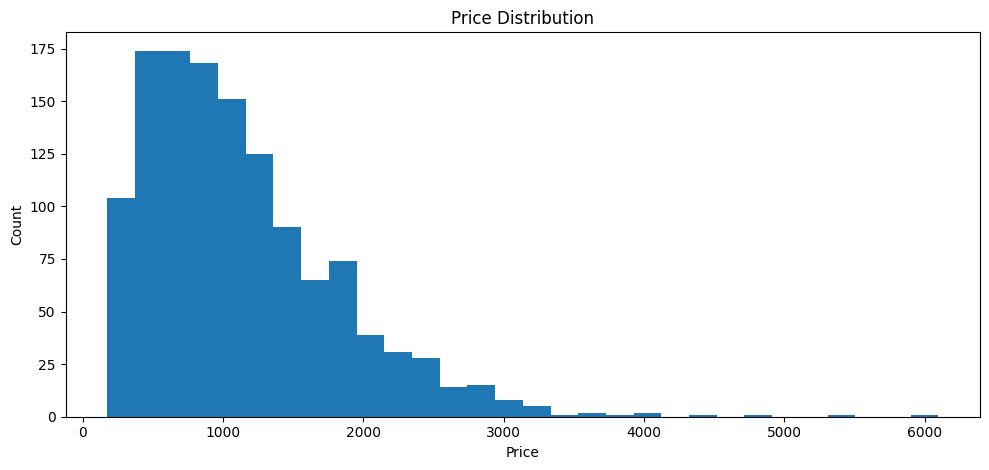

✅ Saved chart: C:\Users\Prath\outputs_laptop_prices\charts\price_distribution.png


'C:\\Users\\Prath\\outputs_laptop_prices\\charts\\price_distribution.png'

In [12]:
# 1) Price distribution
plt.figure(figsize=(10, 4.8))
plt.hist(df[price_col], bins=30)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
save_and_show("price_distribution.png", dpi=cfg.dpi)

**This chart shows the overall distribution of laptop prices across the dataset. It helps identify common price ranges, price concentration, and the presence of very low-cost or high-end laptops.**

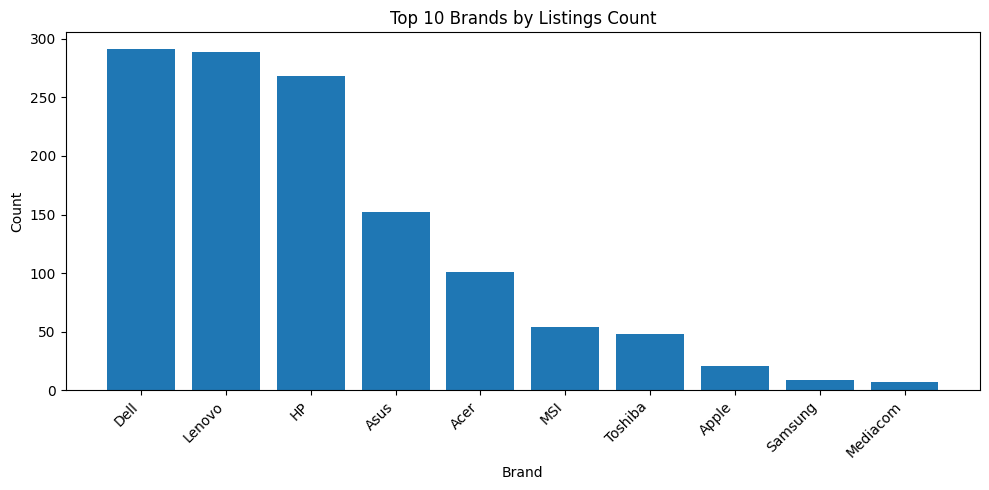

✅ Saved chart: C:\Users\Prath\outputs_laptop_prices\charts\top10_brands_by_count.png


'C:\\Users\\Prath\\outputs_laptop_prices\\charts\\top10_brands_by_count.png'

In [13]:
# 2) Top 10 brands by listing count
top_brand_counts = df["Brand"].value_counts(dropna=True).head(10).reset_index()
top_brand_counts.columns = ["Brand", "Count"]

plt.figure(figsize=(10, 5))
plt.bar(top_brand_counts["Brand"].astype(str), top_brand_counts["Count"])
plt.title("Top 10 Brands by Listings Count")
plt.xlabel("Brand")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
save_and_show("top10_brands_by_count.png", dpi=cfg.dpi)

**This chart highlights the top 10 laptop brands based on the number of listings available in the dataset. It provides insight into which brands are most commonly available and actively competing in the market.**

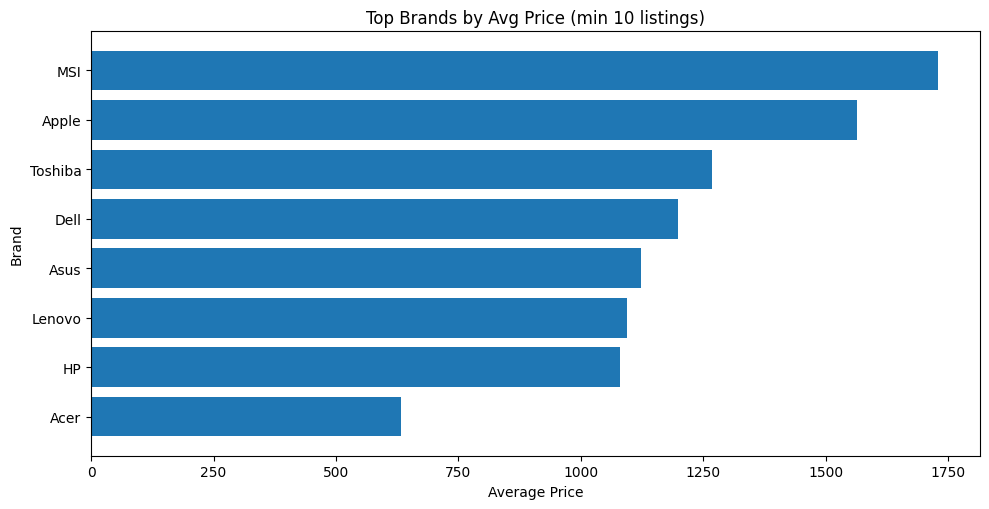

✅ Saved chart: C:\Users\Prath\outputs_laptop_prices\charts\top_brands_avg_price_min10.png


In [14]:
# 3) Brands by average price (min 10 listings)
brand_avg = group_stats(df[df["Brand"].notna()], "Brand", price_col)
brand_avg = brand_avg[brand_avg["count"] >= 10].head(10).sort_values("avg_price")

if len(brand_avg) >= 2:
    plt.figure(figsize=(10, 5.2))
    plt.barh(brand_avg["Brand"].astype(str), brand_avg["avg_price"])
    plt.title("Top Brands by Avg Price (min 10 listings)")
    plt.xlabel("Average Price")
    plt.ylabel("Brand")
    save_and_show("top_brands_avg_price_min10.png", dpi=cfg.dpi)
else:
    print("⚠️ Skipped brand avg price chart (not enough brands with 10+ listings).")


**This visualization shows the brands with the highest average laptop prices (considering brands with sufficient data). It helps identify premium brands and understand brand-level pricing strategies.**

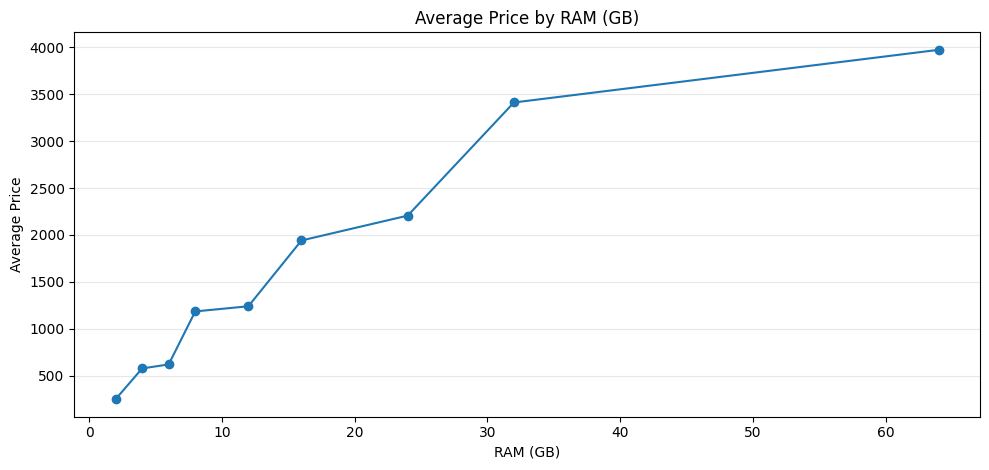

✅ Saved chart: C:\Users\Prath\outputs_laptop_prices\charts\avg_price_by_ram_gb.png


In [15]:
# 4) Avg price by RAM (if available)
if df["RAM_GB"].notna().sum() >= 10:
    ram_avg = (df.groupby("RAM_GB")[price_col].mean().reset_index()
               .dropna()
               .sort_values("RAM_GB"))

    plt.figure(figsize=(10, 4.8))
    plt.plot(ram_avg["RAM_GB"], ram_avg[price_col], marker="o")
    plt.title("Average Price by RAM (GB)")
    plt.xlabel("RAM (GB)")
    plt.ylabel("Average Price")
    plt.grid(True, axis="y", alpha=0.3)
    save_and_show("avg_price_by_ram_gb.png", dpi=cfg.dpi)
else:
    print("⚠️ Skipped RAM chart (RAM info not available / too few rows).")

**This chart demonstrates how laptop prices change with increasing RAM size. It clearly shows that higher RAM configurations generally result in higher average laptop prices, indicating memory capacity as a key pricing factor.**

In [16]:
# 5) Avg price by Storage (if available)
if df["Storage_GB"].notna().sum() >= 10:
    st_avg = (df.groupby("Storage_GB")[price_col].mean().reset_index()
              .dropna()
              .sort_values("Storage_GB"))

    # Keep common sizes to avoid messy plot
    st_avg = st_avg[st_avg["Storage_GB"].isin([128, 256, 512, 1024, 2048])]

    if len(st_avg) >= 2:
        plt.figure(figsize=(10, 4.8))
        plt.bar(st_avg["Storage_GB"].astype(int).astype(str), st_avg[price_col])
        plt.title("Average Price by Storage (GB)")
        plt.xlabel("Storage (GB)")
        plt.ylabel("Average Price")
        plt.grid(True, axis="y", alpha=0.3)
        save_and_show("avg_price_by_storage_gb.png", dpi=cfg.dpi)
    else:
        print("⚠️ Skipped storage chart (not enough common storage sizes found).")
else:
    print("⚠️ Skipped storage chart (storage info not available / too few rows).")


⚠️ Skipped storage chart (storage info not available / too few rows).


**This chart illustrates the relationship between storage capacity and laptop prices.
Laptops with higher storage capacities, especially SSD-based configurations, tend to have higher average prices.**

In [17]:
print("\n✅ DONE!")
print("📁 Tables saved in:", os.path.abspath(TABLES_DIR))
print("📁 Charts saved in:", os.path.abspath(CHARTS_DIR))
print("📄 Example chart files:", sorted(os.listdir(CHARTS_DIR))[:10])



✅ DONE!
📁 Tables saved in: C:\Users\Prath\outputs_laptop_prices\tables
📁 Charts saved in: C:\Users\Prath\outputs_laptop_prices\charts
📄 Example chart files: ['avg_price_by_ram_gb.png', 'price_distribution.png', 'top10_brands_by_count.png', 'top_brands_avg_price_min10.png']


**Business Use:**  
**These insights can help retailers decide optimal pricing strategies and assist customers in choosing laptops based on budget and performance needs.**


**Step 9: Conclusion**

**This project analyzed laptop pricing data using Python to uncover trends, patterns, and key pricing drivers. Through data cleaning, exploratory analysis, KPI generation, and visualization, meaningful insights were extracted from real-world data.
The analysis shows that laptop pricing is significantly influenced by brand, RAM size, and storage capacity. These insights can help customers make informed purchasing decisions and assist businesses in understanding market positioning and pricing strategies**